In [50]:
import json
import glob
import ast
import gzip
import os
import yaml
from tqdm import tqdm
import re
from collections import defaultdict


import lightgbm as lgb
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import math
import warnings
import pickle
import time
import lightgbm as lgm
import datetime
import ast
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K


from datetime import date, time
from lightgbm import LGBMClassifier, LGBMRegressor
from pandas.plotting import scatter_matrix
from scipy import interp
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.sparse import csr_matrix, hstack

#MODELS
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2 
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, log_loss, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from statsmodels.graphics.gofplots import qqplot

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

%matplotlib inline
warnings.filterwarnings('ignore')

%matplotlib inline

In [51]:
df = pd.read_csv("scaled_filtered_24_4_10.csv", nrows = 1000
                )

In [52]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df)

,Unnamed: 0,combat_id,start_time,number_of_rounds,player_ids,player_info,monsters_info,party_size,total_slots,total_max_slots,party_classes_with_level,party_total_class_composition,player_individual_hp_ratios,player_individual_ac,player_individual_prof_bonus,player_individual_strength,player_individual_dexterity,player_individual_constitution,player_individual_intelligence,player_individual_wisdom,player_individual_charisma,monster_types,monster_number,monster_total_level,party_total_level,party_level1_spellslots,party_level2_spellslots,party_level3_spellslots,party_level4_spellslots,party_level5_spellslots,party_level6_spellslots,party_level7_spellslots,party_level8_spellslots,party_level9_spellslots,party_total_ac,party_total_precombat_hp,party_total_postcombat_hp,party_total_hpratio,party_total_prof_bonus,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,party_total_charisma,player_monster_ratio,monster_player_ratio,party_max_hp,Blood Hunter,Wizard,Fighter,Paladin,Bard,Cleric,Warlock,Ranger,Barbarian,Druid,Monk,Sorcerer,Rogue,weighted_monster_level,weighted_spell_slots
0,1,1653817902-15ec25a2-6757-4ceb-ac41-d44352b97705,1653817902.74,1,['209330647903743785'],"[{'hp_ratio': (65, 65), 'class': [('Ranger', 1...",[{'monster_id': 'c0cdb522-64c2-42ee-b1a8-6ef22...,1,"{'1': 4, '2': 3, '3': 2, '4': 0, '5': 0, '6': ...","{'1': 4, '2': 3, '3': 2, '4': 0, '5': 0, '6': ...","[('Ranger', 10)]",['Ranger'],"[(65, 65)]",[17],[4],[14],[16],[12],[12],[14],[11],['Warrior (level 4)'],1,4.00,10,4,3,2,0,0,0,0,0,0,17,65,65,1.00,4,14,16,12,12,14,11,1.00,1.00,65,0,0,0,0,0,0,0,1,0,0,0,0,0,4.00,139
1,14,1653869871-e7fd0606-de62-4688-a55b-ae4c25a14beb,1653869871.84,2,['176588704091156599'],"[{'hp_ratio': (0, 38), 'class': [('Monk', 4), ...",[{'monster_id': '3bdb4cc1-6ca9-47e8-9610-d68ef...,1,"{'1': 2, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","{'1': 2, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","[('Monk', 4), ('Cleric', 1)]","['Monk', 'Cleric']","[(0, 38)]",[14],[3],[14],[16],[14],[10],[13],[13],"['Flying Sword', 'Flying Sword', 'Black Dragon...",3,2.50,5,2,0,0,0,0,0,0,0,0,14,38,0,0.00,3,14,16,14,10,13,13,0.33,3.00,38,0,0,0,0,0,1,0,0,0,0,1,0,0,5.00,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,2501,1656164288-ca976d7b-46c8-41f8-87fd-941e98f4f480,1656164288.95,4,['321444462285149813'],"[{'hp_ratio': (93, 93), 'class': [('Rogue', 8)...",[{'monster_id': '2f943457-2c0c-4ec6-bdae-94b20...,1,"{'1': 1, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","{'1': 1, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","[('Rogue', 8), ('Fighter', 6)]","['Rogue', 'Fighter']","[(93, 93)]",[17],[5],[13],[19],[13],[8],[13],[15],['Devourer'],1,13.00,14,1,0,0,0,0,0,0,0,0,17,93,93,1.00,5,13,19,13,8,13,15,1.00,1.00,93,0,0,1,0,0,0,0,0,0,0,0,0,1,13.00,6
999,2502,1656164636-fe43bf4e-136c-480f-a246-df9aaebf9435,1656164636.27,6,"['159332117133051198', '326793710699339197', '...","[{'hp_ratio': (131, 191), 'class': [('Druid', ...",[{'monster_id': 'b60669e9-c580-4965-a850-fdbc3...,5,"{'1': 13, '2': 9, '3': 9, '4': 9, '5': 7, '6':...","{'1': 14, '2': 9, '3': 9, '4': 9, '5': 7, '6':...","[('Druid', 17), ('Fighter', 17), ('Rogue', 8),...","['Druid', 'Fighter', 'Rogue', 'Fighter', 'Sorc...","[(131, 191), (129, 175), (92, 175), (123, 158)...","[23, 18, 24, 24, 18]","[6, 6, 6, 6, 6]","[11, 13, 12, 8, 13]","[12, 20, 20, 14, 16]","[19, 14, 16, 16, 20]","[9, 10, 12, 12, 22]","[20, 20, 15, 12, 13]","[14, 8, 10, 20, 8]",['Dracohydra'],1,11.00,91,13,9,9,9,7,2,4,3,1,107,776,620,0.80,30,57,82,85,65,80,60,5.00,0.20,881,0,1,1,0,0,0,1,0,0,1,0,1,1,11.00,2256


In [53]:
df.columns

Index(['Unnamed: 0', 'combat_id', 'start_time', 'number_of_rounds',
       'player_ids', 'player_info', 'monsters_info', 'party_size',
       'total_slots', 'total_max_slots', 'party_classes_with_level',
       'party_total_class_composition', 'player_individual_hp_ratios',
       'player_individual_ac', 'player_individual_prof_bonus',
       'player_individual_strength', 'player_individual_dexterity',
       'player_individual_constitution', 'player_individual_intelligence',
       'player_individual_wisdom', 'player_individual_charisma',
       'monster_types', 'monster_number', 'monster_total_level',
       'party_total_level', 'party_level1_spellslots',
       'party_level2_spellslots', 'party_level3_spellslots',
       'party_level4_spellslots', 'party_level5_spellslots',
       'party_level6_spellslots', 'party_level7_spellslots',
       'party_level8_spellslots', 'party_level9_spellslots', 'party_total_ac',
       'party_total_precombat_hp', 'party_total_postcombat_hp',
       '

In [64]:
df = df[['number_of_rounds',
         'party_size',
         'monster_number',
         'monster_total_level',
         'party_total_level', 
         'party_level1_spellslots',
         'party_level2_spellslots', 
         'party_level3_spellslots',
         'party_level4_spellslots', 
         'party_level5_spellslots',
         'party_level6_spellslots', 
         'party_level7_spellslots',
         'party_level8_spellslots', 
         'party_level9_spellslots',
         'party_total_ac',
         'party_total_charisma',
         'player_monster_ratio', 
         'monster_player_ratio',
         'party_max_hp',
         'Druid',
         'party_total_strength', 
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'Cleric',
         'Wizard',
         'Rogue',
         'Warlock',
         'Sorcerer',
         'Blood Hunter',
         'Monk',
         'Bard',
         'Barbarian',
         'Fighter',
         'Paladin',
         'Ranger',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']] 

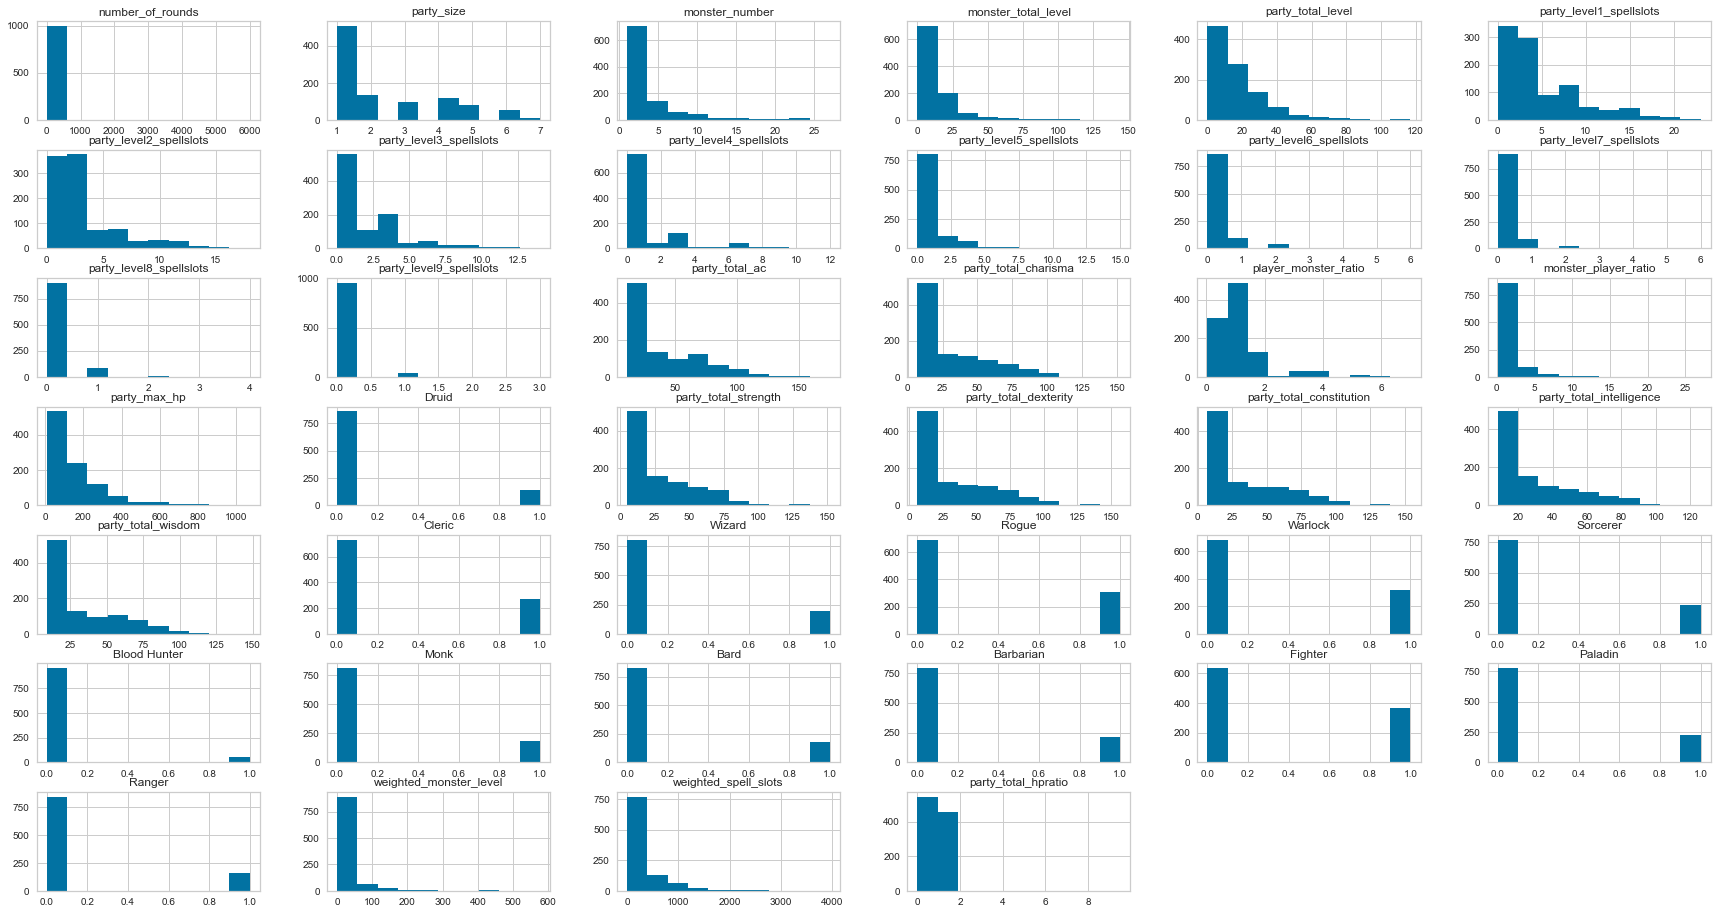

In [65]:
df.hist(figsize=(30, 16));

## CORRELATION

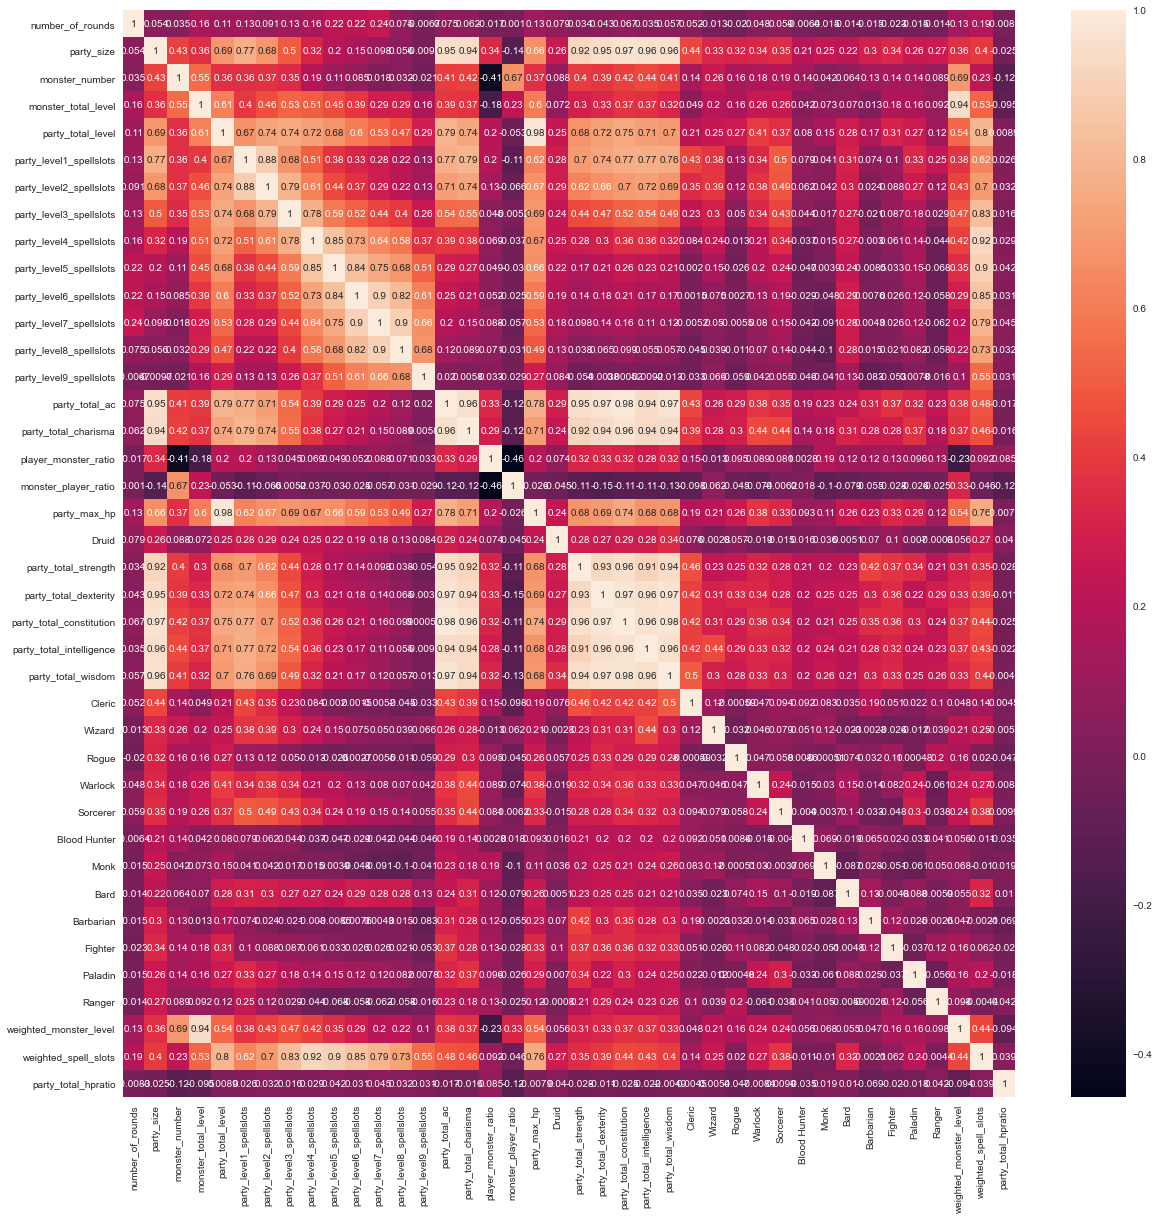

In [66]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)
plt.show()

## BASIC METRICS / STATS

In [67]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_rounds,1000.00,10.11,189.88,0.00,2.00,3.00,5.00,6007.00
party_size,1000.00,2.32,1.66,1.00,1.00,1.00,4.00,7.00
monster_number,1000.00,3.42,4.16,1.00,1.00,2.00,4.00,27.00
monster_total_level,1000.00,12.96,16.36,0.00,3.00,8.00,15.00,144.00
party_total_level,1000.00,17.74,15.86,0.00,7.00,13.00,24.00,117.00
party_level1_spellslots,1000.00,4.86,4.68,0.00,1.00,4.00,8.00,23.00
party_level2_spellslots,1000.00,2.93,3.25,0.00,0.00,3.00,4.00,18.00
party_level3_spellslots,1000.00,1.83,2.60,0.00,0.00,0.00,3.00,14.00
party_level4_spellslots,1000.00,1.05,2.03,0.00,0.00,0.00,2.00,12.00
party_level5_spellslots,1000.00,0.65,1.48,0.00,0.00,0.00,0.00,15.00


In [68]:
df.head(10)

,number_of_rounds,party_size,monster_number,monster_total_level,party_total_level,party_level1_spellslots,party_level2_spellslots,party_level3_spellslots,party_level4_spellslots,party_level5_spellslots,...,Blood Hunter,Monk,Bard,Barbarian,Fighter,Paladin,Ranger,weighted_monster_level,weighted_spell_slots,party_total_hpratio
0,1,1,1,4.00,10,4,3,2,0,0,...,0,0,0,0,0,0,1,4.00,139,1.00
1,2,1,3,2.50,5,2,0,0,0,0,...,0,1,0,0,0,0,0,5.00,12,0.00
2,4,2,1,4.00,17,4,3,3,3,1,...,0,0,0,1,0,0,0,4.00,367,1.07
3,6,2,5,6.00,18,7,3,3,3,2,...,0,0,0,1,0,0,0,12.00,449,0.87
4,2,4,1,1.00,58,18,11,5,3,2,...,0,0,1,1,1,1,0,1.00,871,0.99
5,2,4,7,2.00,58,18,11,5,3,2,...,0,0,1,1,1,1,0,5.00,871,1.00
6,8,5,3,4.50,16,7,4,0,0,0,...,0,0,0,1,1,0,1,9.00,110,0.76
7,5,3,3,0.75,9,3,0,0,0,0,...,0,0,1,0,1,0,1,1.50,18,0.76
8,2,4,5,20.00,58,18,11,4,3,2,...,0,0,1,1,1,1,0,40.00,839,0.88
9,7,2,1,4.00,29,4,0,0,0,0,...,0,1,0,1,0,0,0,4.00,24,0.67


## PYCARAT

In [69]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format 
from pycaret.regression import *

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number_of_rounds          1000 non-null   int64  
 1   party_size                1000 non-null   int64  
 2   monster_number            1000 non-null   int64  
 3   monster_total_level       1000 non-null   float64
 4   party_total_level         1000 non-null   int64  
 5   party_level1_spellslots   1000 non-null   int64  
 6   party_level2_spellslots   1000 non-null   int64  
 7   party_level3_spellslots   1000 non-null   int64  
 8   party_level4_spellslots   1000 non-null   int64  
 9   party_level5_spellslots   1000 non-null   int64  
 10  party_level6_spellslots   1000 non-null   int64  
 11  party_level7_spellslots   1000 non-null   int64  
 12  party_level8_spellslots   1000 non-null   int64  
 13  party_level9_spellslots   1000 non-null   int64  
 14  party_tot

In [71]:
df.head(1)

,number_of_rounds,party_size,monster_number,monster_total_level,party_total_level,party_level1_spellslots,party_level2_spellslots,party_level3_spellslots,party_level4_spellslots,party_level5_spellslots,...,Blood Hunter,Monk,Bard,Barbarian,Fighter,Paladin,Ranger,weighted_monster_level,weighted_spell_slots,party_total_hpratio
0,1,1,1,4.00,10,4,3,2,0,0,...,0,0,0,0,0,0,1,4.00,139,1.00


In [72]:
df.corr()['party_total_hpratio'].sort_values()

monster_player_ratio       -0.12
monster_number             -0.12
monster_total_level        -0.09
weighted_monster_level     -0.09
Barbarian                  -0.07
Rogue                      -0.05
Blood Hunter               -0.03
party_total_strength       -0.03
party_size                 -0.03
party_total_constitution   -0.03
party_total_intelligence   -0.02
Fighter                    -0.02
Paladin                    -0.02
party_total_ac             -0.02
party_total_charisma       -0.02
party_total_dexterity      -0.01
Warlock                    -0.01
number_of_rounds           -0.01
party_max_hp               -0.01
Wizard                     -0.01
party_total_wisdom         -0.00
Cleric                      0.00
party_total_level           0.01
Sorcerer                    0.01
Bard                        0.01
party_level3_spellslots     0.02
Monk                        0.02
party_level1_spellslots     0.03
party_level4_spellslots     0.03
party_level6_spellslots     0.03
party_leve

In [73]:
# This is the setup function in Pycaret and is the first step you do. There are are ton of parameters you can use inside of it. 
# You can read about it here https:..


#//pycaret.readthedocs.io/en/stable/api/regression.html#

reg_setup= setup(data = df, target = 'party_total_hpratio', html = False)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
number_of_rounds,Numeric
party_size,Categorical
monster_number,Numeric
monster_total_level,Numeric
party_total_level,Numeric
party_level1_spellslots,Numeric
party_level2_spellslots,Categorical
party_level3_spellslots,Categorical
party_level4_spellslots,Categorical
party_level5_spellslots,Categorical


Setup Succesfully Completed!


,Description,Value
0,session_id,6981
1,Target,party_total_hpratio
2,Original Data,"(1000, 40)"
3,Missing Values,False
4,Numeric Features,17
5,Categorical Features,22
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(699, 106)"


In [74]:
# #The compare models function iteratively adds one model at a time and filters the best model to the top. If you scroll to the bottom, it looks like
# the best model it came up with was Orthogonal Matching Pursuit. If you only want to focus on one or a few metrics though, you can just see
# which one scored the best. FYI, this is a starting point, it actually doesn't build the model. We can do that in the next step.


best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69
par,Passive Aggressive Regressor,0.81,64.69,3.17,-944.20,0.35,1.36,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69
par,Passive Aggressive Regressor,0.81,64.69,3.17,-944.20,0.35,1.36,0.01
huber,Huber Regressor,0.80,207.45,4.85,-3031.89,0.25,1.32,0.03


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69
par,Passive Aggressive Regressor,0.81,64.69,3.17,-944.20,0.35,1.36,0.01
huber,Huber Regressor,0.80,207.45,4.85,-3031.89,0.25,1.32,0.03


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69
par,Passive Aggressive Regressor,0.81,64.69,3.17,-944.20,0.35,1.36,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ada,AdaBoost Regressor,0.23,0.08,0.29,-0.13,0.17,0.45,0.10
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ada,AdaBoost Regressor,0.23,0.08,0.29,-0.13,0.17,0.45,0.10
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ada,AdaBoost Regressor,0.23,0.08,0.29,-0.13,0.17,0.45,0.10
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
lightgbm,Light Gradient Boosting Machine,0.18,0.06,0.25,0.13,0.16,0.41,1.46
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ada,AdaBoost Regressor,0.23,0.08,0.29,-0.13,0.17,0.45,0.10


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.17,0.06,0.24,0.24,0.15,0.39,1.37
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
lightgbm,Light Gradient Boosting Machine,0.18,0.06,0.25,0.13,0.16,0.41,1.46
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.17,0.06,0.24,0.24,0.15,0.39,1.37
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
lightgbm,Light Gradient Boosting Machine,0.18,0.06,0.25,0.13,0.16,0.41,1.46
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.17,0.06,0.24,0.24,0.15,0.39,1.37
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
lightgbm,Light Gradient Boosting Machine,0.18,0.06,0.25,0.13,0.16,0.41,1.46
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53


In [75]:
# Since I am not familiar with Orthogonal Matching Pursuit, I am just going to use Gradient Boosting Regressor. 
# Build model here for Gradient Boosting Regressor. Use the model id to build whichever one you like (rf, lightgbm, gbr, etc..). Folds
# are the different cross-validation folds

catboost_model = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.18,0.07,0.27,0.35,0.17,0.47
1,0.20,0.09,0.30,0.10,0.19,0.34
2,0.16,0.06,0.24,0.29,0.15,0.41
3,0.17,0.05,0.23,0.26,0.14,0.52
4,0.17,0.06,0.25,0.10,0.14,0.28
5,0.13,0.03,0.18,0.17,0.11,0.18
6,0.15,0.05,0.21,0.35,0.14,0.56
7,0.16,0.05,0.22,0.29,0.14,0.45
8,0.16,0.05,0.21,0.12,0.13,0.23


In [76]:
# Tune the model here. This finds the best hyperparameters for the model. There is a parameter called n_iter
# setting this to 3 to speed up but you can play with that number

tuned_catboost_model = tune_model(catboost_model, n_iter = 10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.18,0.07,0.26,0.35,0.17,0.49
1,0.20,0.09,0.30,0.09,0.19,0.33
2,0.16,0.05,0.23,0.32,0.15,0.42
3,0.17,0.05,0.22,0.29,0.13,0.52
4,0.17,0.06,0.25,0.13,0.14,0.28
5,0.13,0.03,0.18,0.16,0.11,0.19
6,0.15,0.04,0.20,0.41,0.13,0.51
7,0.17,0.06,0.24,0.20,0.15,0.47
8,0.16,0.05,0.22,0.02,0.14,0.24


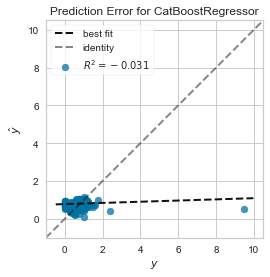

In [77]:
#Can visulize errors using this

plot_model(tuned_catboost_model, plot = 'error')

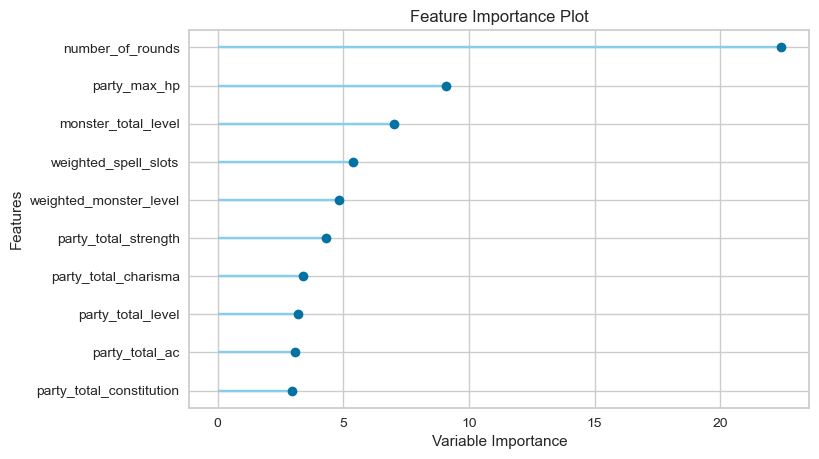

In [78]:
#Can visulize feature importance using this

plot_model(tuned_catboost_model, plot='feature')

## XgBoost

In [79]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [80]:
## import xgboost
import xgboost

In [81]:
df = df[['number_of_rounds',
         'party_size',
         'monster_number',
         'monster_total_level',
         'party_total_level', 
         'party_level1_spellslots',
         'party_level2_spellslots', 
         'party_level3_spellslots',
         'party_level4_spellslots', 
         'party_level5_spellslots',
         'party_level6_spellslots', 
         'party_level7_spellslots',
         'party_level8_spellslots', 
         'party_level9_spellslots',
         'party_total_ac',
         'party_total_charisma',
         'player_monster_ratio', 
         'monster_player_ratio',
         'party_max_hp',
         'Druid',
         'party_total_strength', 
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'Cleric',
         'Wizard',
         'Rogue',
         'Warlock',
         'Sorcerer',
         'Blood Hunter',
         'Monk',
         'Bard',
         'Barbarian',
         'Fighter',
         'Paladin',
         'Ranger',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']] 

In [82]:
#df = df.select_dtypes(exclude=['object'])

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number_of_rounds          10842 non-null  int64  
 1   party_size                10842 non-null  int64  
 2   monster_number            10842 non-null  int64  
 3   monster_total_level       10842 non-null  float64
 4   party_total_level         10842 non-null  int64  
 5   party_level1_spellslots   10842 non-null  int64  
 6   party_level2_spellslots   10842 non-null  int64  
 7   party_level3_spellslots   10842 non-null  int64  
 8   party_level4_spellslots   10842 non-null  int64  
 9   party_level5_spellslots   10842 non-null  int64  
 10  party_level6_spellslots   10842 non-null  int64  
 11  party_level7_spellslots   10842 non-null  int64  
 12  party_level8_spellslots   10842 non-null  int64  
 13  party_level9_spellslots   10842 non-null  int64  
 14  party_

## Define X, y

In [84]:
y = df.pop('party_total_hpratio')
X = df

## Test Train Split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Build XgBoost Regressor Model

In [86]:
df.head(1)

,number_of_rounds,party_size,monster_number,monster_total_level,party_total_level,party_level1_spellslots,party_level2_spellslots,party_level3_spellslots,party_level4_spellslots,party_level5_spellslots,...,Sorcerer,Blood Hunter,Monk,Bard,Barbarian,Fighter,Paladin,Ranger,weighted_monster_level,weighted_spell_slots
0,1,1,1,4.00,10,4,3,2,0,0,...,0,0,0,0,0,0,0,1,4.00,139


In [87]:
import xgboost as xgb 

parameters = {#'nthread':[12], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.1], #so called `eta` value
              'max_depth': [7],
#              'min_child_weight': [1], # originally tried 4
#              'subsample': [0.7],
#              'colsample_bytree': [0.7],
              'n_estimators': [100]}

xgb = xgboost.XGBRegressor(n_estimators=1000, 
                   max_depth=20, 
                   eta=0.4, 
                   subsample=0.7, 
                   colsample_bytree=0.8)

xgb_gridsearch = GridSearchCV(xgboost.XGBRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

xgb_gridsearch.fit(X_train, y_train)

print( "best parameters:", xgb_gridsearch.best_params_ )

best_xgb_model = xgb_gridsearch.best_estimator_



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-10)]: Done   5 out of   5 | elapsed:    2.5s finished


best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [88]:
def score_model(best_xgb_model, X_train, y_train):
    MSE = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [89]:
print('xgb:', score_model(best_xgb_model, X_train, y_train))

xgb: (0.6570733440684755, -1.3409356598051154)


In [90]:
def score_model(xgb, X_train, y_train):
    MSE = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [91]:
def score_model(xgb, X_train, y_train):
    MSE = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [92]:
print('xgb:', score_model(xgb, X_train, y_train))

xgb: (0.6962981487023014, -1.979091003224503)


In [93]:
mse = mean_squared_error(y_test, best_xgb_model.predict(X_test))
rmse = mean_squared_error(y_test, best_xgb_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_xgb_model.predict(X_test)) 

In [94]:
rmse = mean_squared_error(y_test, best_xgb_model.predict(X_test)) ** 0.5

In [95]:
r2 = r2_score(y_test, best_xgb_model.predict(X_test)) 

In [96]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Mean Squared Error: 0.5598909899341928
Root Mean Squared Error: 0.7482586383959713
R-squared Score: -1.1938868882696085


In [99]:
plot_model(best_xgb_model, plot='feature')

ValueError: arrays must all be same length

In [15]:
y_hat = best_xgb_model.predict(X_test)

In [16]:
def r2(y, y_hat):
    return 1-((y-y_hat)**2).sum()/((y-y.mean())**2).sum()
def rmse(y, y_hat):
    return (((y-y_hat)**2).sum()/y.shape[0])**0.5

In [17]:
r2(y_test, y_hat), sklearn.metrics.r2_score(y_test, y_hat)

(-6.517882384162452, -6.517882384162452)

In [ ]:
xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print( "best parameters:", xgb_gridsearch.best_params_ )

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
...
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

## CatBoost 

In [103]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [104]:
df = df[['number_of_rounds',
         'party_size',
         'monster_number',
         'monster_total_level',
         'party_total_level', 
         'party_level1_spellslots',
         'party_level2_spellslots', 
         'party_level3_spellslots',
         'party_level4_spellslots', 
         'party_level5_spellslots',
         'party_level6_spellslots', 
         'party_level7_spellslots',
         'party_level8_spellslots', 
         'party_level9_spellslots',
         'party_total_ac',
         'party_total_charisma',
         'player_monster_ratio', 
         'monster_player_ratio',
         'party_max_hp',
         'Druid',
         'party_total_strength', 
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'Cleric',
         'Wizard',
         'Rogue',
         'Warlock',
         'Sorcerer',
         'Blood Hunter',
         'Monk',
         'Bard',
         'Barbarian',
         'Fighter',
         'Paladin',
         'Ranger',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']] 

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number_of_rounds          10842 non-null  int64  
 1   party_size                10842 non-null  int64  
 2   monster_number            10842 non-null  int64  
 3   monster_total_level       10842 non-null  float64
 4   party_total_level         10842 non-null  int64  
 5   party_level1_spellslots   10842 non-null  int64  
 6   party_level2_spellslots   10842 non-null  int64  
 7   party_level3_spellslots   10842 non-null  int64  
 8   party_level4_spellslots   10842 non-null  int64  
 9   party_level5_spellslots   10842 non-null  int64  
 10  party_level6_spellslots   10842 non-null  int64  
 11  party_level7_spellslots   10842 non-null  int64  
 12  party_level8_spellslots   10842 non-null  int64  
 13  party_level9_spellslots   10842 non-null  int64  
 14  party_

In [106]:
y = df.pop('party_total_hpratio')
X = df

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [111]:
#parameters = {learning_rate=[0.1],
 #                       iterations=[50],
 #                       depth=[10],
 ##                       n_estimators=[100],
  ##                      verbose=[10],
  #                      loss_function='RMSE',
 #                       random_state=[1]}

#catb = catboost.CatBoostRegressor(n_estimators=1000, 
 #                  max_depth=20, 
 #                  eta=0.4, 
 #                  subsample=0.7, 
  #                 colsample_bytree=0.8)

catb = CatBoostRegressor(
                        learning_rate=0.1,
                        iterations=50,
                        depth=10,
                        n_estimators=100,
                        verbose=10,
                        loss_function='RMSE',
                        random_state=1)

catb_gridsearch = GridSearchCV(CatBoostRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

catb_gridsearch.fit(X_train, y_train)

print( "best parameters:", catb_gridsearch.best_params_ )

best_catb_model = catb_gridsearch.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.7150664	total: 5.93ms	remaining: 587ms
1:	learn: 0.7107791	total: 8.53ms	remaining: 418ms
2:	learn: 0.7080392	total: 10.8ms	remaining: 351ms
3:	learn: 0.6980417	total: 14ms	remaining: 336ms
4:	learn: 0.6944273	total: 16.3ms	remaining: 310ms
5:	learn: 0.6837893	total: 19.2ms	remaining: 300ms
6:	learn: 0.6743407	total: 21.8ms	remaining: 289ms
7:	learn: 0.6714173	total: 24.2ms	remaining: 278ms
8:	learn: 0.6690149	total: 26.6ms	remaining: 269ms
9:	learn: 0.6570920	total: 29.1ms	remaining: 262ms
10:	learn: 0.6454640	total: 31.9ms	remaining: 258ms
11:	learn: 0.6437063	total: 34.8ms	remaining: 255ms
12:	learn: 0.6351359	total: 37.1ms	remaining: 249ms
13:	learn: 0.6329672	total: 39.4ms	remaining: 242ms
14:	learn: 0.6228080	total: 41.6ms	remaining: 236ms
15:	learn: 0.6211198	total: 43.9ms	remaining: 231ms
16:	learn: 0.6131562	total: 46.9ms	remaining: 229ms
17:	learn: 0.6031398	total: 50ms	remaining: 228ms
18:	learn: 0.601087

[Parallel(n_jobs=-10)]: Using backend SequentialBackend with 1 concurrent workers.


48:	learn: 0.4796916	total: 125ms	remaining: 130ms
49:	learn: 0.4786572	total: 128ms	remaining: 128ms
50:	learn: 0.4735183	total: 131ms	remaining: 126ms
51:	learn: 0.4625849	total: 134ms	remaining: 124ms
52:	learn: 0.4616152	total: 139ms	remaining: 123ms
53:	learn: 0.4605171	total: 142ms	remaining: 121ms
54:	learn: 0.4595643	total: 145ms	remaining: 119ms
55:	learn: 0.4586343	total: 148ms	remaining: 116ms
56:	learn: 0.4537156	total: 151ms	remaining: 114ms
57:	learn: 0.4495439	total: 154ms	remaining: 111ms
58:	learn: 0.4463271	total: 156ms	remaining: 109ms
59:	learn: 0.4404382	total: 159ms	remaining: 106ms
60:	learn: 0.4395976	total: 162ms	remaining: 104ms
61:	learn: 0.4294481	total: 165ms	remaining: 101ms
62:	learn: 0.4238754	total: 168ms	remaining: 98.8ms
63:	learn: 0.4230903	total: 171ms	remaining: 96.1ms
64:	learn: 0.4223401	total: 173ms	remaining: 93.3ms
65:	learn: 0.4216146	total: 176ms	remaining: 90.6ms
66:	learn: 0.4209169	total: 178ms	remaining: 87.8ms
67:	learn: 0.4202012	total

[Parallel(n_jobs=-10)]: Done   5 out of   5 | elapsed:    1.9s finished


33:	learn: 0.5492563	total: 110ms	remaining: 213ms
34:	learn: 0.5432804	total: 113ms	remaining: 210ms
35:	learn: 0.5420975	total: 118ms	remaining: 209ms
36:	learn: 0.5362304	total: 121ms	remaining: 207ms
37:	learn: 0.5352851	total: 125ms	remaining: 205ms
38:	learn: 0.5344103	total: 131ms	remaining: 205ms
39:	learn: 0.5297372	total: 136ms	remaining: 204ms
40:	learn: 0.5229496	total: 146ms	remaining: 210ms
41:	learn: 0.5219741	total: 151ms	remaining: 208ms
42:	learn: 0.5209512	total: 158ms	remaining: 209ms
43:	learn: 0.5200818	total: 162ms	remaining: 206ms
44:	learn: 0.5193493	total: 167ms	remaining: 204ms
45:	learn: 0.5142410	total: 171ms	remaining: 201ms
46:	learn: 0.5135606	total: 175ms	remaining: 197ms
47:	learn: 0.5083936	total: 179ms	remaining: 193ms
48:	learn: 0.5075765	total: 184ms	remaining: 191ms
49:	learn: 0.5025684	total: 189ms	remaining: 189ms
50:	learn: 0.5020879	total: 194ms	remaining: 186ms
51:	learn: 0.5014788	total: 197ms	remaining: 182ms
52:	learn: 0.4975704	total: 202

In [112]:
def score_model(best_catb_model, X_train, y_train):
    MSE = cross_val_score(best_catb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(best_catb_model, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [122]:
mse = mean_squared_error(y_test, best_catb_model.predict(X_test))
rmse = mean_squared_error(y_test, best_catb_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_catb_model.predict(X_test)) 

In [124]:
print("catb - Mean Squared Error:", mse)
print("catb - Root Mean Squared Error:", rmse)
print("catb - R-squared Score:", r2)

catb - Mean Squared Error: 0.28018020279243855
catb - Root Mean Squared Error: 0.5293205104588699
catb - R-squared Score: -0.09786312748361636


In [125]:
print('catb:', score_model(best_catb_model, X_train, y_train))

0:	learn: 0.7150664	total: 5.63ms	remaining: 557ms
1:	learn: 0.7107791	total: 8.49ms	remaining: 416ms
2:	learn: 0.7080392	total: 12.3ms	remaining: 398ms
3:	learn: 0.6980417	total: 16.4ms	remaining: 395ms
4:	learn: 0.6944273	total: 21.2ms	remaining: 404ms
5:	learn: 0.6837893	total: 25.9ms	remaining: 406ms
6:	learn: 0.6743407	total: 29.6ms	remaining: 393ms
7:	learn: 0.6714173	total: 32.9ms	remaining: 378ms
8:	learn: 0.6690149	total: 35.7ms	remaining: 361ms
9:	learn: 0.6570920	total: 38.6ms	remaining: 347ms
10:	learn: 0.6454640	total: 42.4ms	remaining: 343ms
11:	learn: 0.6437063	total: 45.8ms	remaining: 336ms
12:	learn: 0.6351359	total: 48.6ms	remaining: 325ms
13:	learn: 0.6329672	total: 51.1ms	remaining: 314ms
14:	learn: 0.6228080	total: 53.4ms	remaining: 303ms
15:	learn: 0.6211198	total: 56.3ms	remaining: 295ms
16:	learn: 0.6131562	total: 59.3ms	remaining: 289ms
17:	learn: 0.6031398	total: 61.6ms	remaining: 281ms
18:	learn: 0.6010872	total: 63.9ms	remaining: 272ms
19:	learn: 0.5927090	t

## AdaBoost

In [169]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [170]:
df = df[['number_of_rounds',
         'party_size',
         'monster_number',
         'monster_total_level',
         'party_total_level', 
         'party_level1_spellslots',
         'party_level2_spellslots', 
         'party_level3_spellslots',
         'party_level4_spellslots', 
         'party_level5_spellslots',
         'party_level6_spellslots', 
         'party_level7_spellslots',
         'party_level8_spellslots', 
         'party_level9_spellslots',
         'party_total_ac',
         'party_total_charisma',
         'player_monster_ratio', 
         'monster_player_ratio',
         'party_max_hp',
         'Druid',
         'party_total_strength', 
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'Cleric',
         'Wizard',
         'Rogue',
         'Warlock',
         'Sorcerer',
         'Blood Hunter',
         'Monk',
         'Bard',
         'Barbarian',
         'Fighter',
         'Paladin',
         'Ranger',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']] 

In [171]:
y = df.pop('party_total_hpratio')
X = df

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [206]:
dtr = DecisionTreeRegressor(max_depth=10)
abr = AdaBoostRegressor(base_estimator=dtr, n_estimators=100, learning_rate=0.1, loss='linear', random_state=42)

abr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=10,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                 

In [207]:
y_pred = abr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.24093203824285533


In [208]:
mse = mean_squared_error(y_test, abr.predict(X_test))
rmse = mean_squared_error(y_test, abr.predict(X_test)) ** 0.5
r2 = r2_score(y_test, abr.predict(X_test)) 

In [209]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Mean Squared Error: 0.24093203824285533
Root Mean Squared Error: 0.490848284343396
R-squared Score: 0.055927583819130655


In [198]:
ada = AdaBoostRegressor(
                        learning_rate=0.1,
                       # iterations=50,
              #          depth=10,
                        n_estimators=100,
            #            verbose=10,
           #             loss_function='RMSE',
                        random_state=1)

ada_gridsearch = GridSearchCV(AdaBoostRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

    
ada_gridsearch.fit(X_train, y_train)


print( "best parameters:", ada_gridsearch.best_params_ )

best_ada_model = ada_gridsearch.best_estimator_


NameError: name 'adaboost' is not defined

In [196]:
ada = AdaBoostRegressor()

ada_grid =      {'n_estimators':[500,1000,2000],
                 'learning_rate':[.001,0.01,.1],
                 'random_state':[1]}

grid_ADA = GridSearchCV((ada,
                         scoring='neg_mean_squared_error',
                         n_jobs=1,
                         cv=crossvalidation)
    
grid_ADA.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_ADA.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_ADA.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_ADA.best_params_)

best_ada_model = grid_ADA.best_estimator_

SyntaxError: invalid syntax (<ipython-input-196-eeaadf0f5309>, line 8)

In [151]:
ada = AdaBoostRegressor()

ada_grid =      {'n_estimators':[500,1000,2000],
                 'learning_rate':[.001,0.01,.1],
                 'random_state':[1]}

grid_ADA = GridSearchCV((ada,
                      #   scoring = 'neg_mean_squared_error',
                         n_jobs=1,
                         cv=crossvalidation)
    
grid_ADA.fit(X_train, y_train)
                        
best_ada_model = grid_ADA.best_estimator_
##################
ada = AdaBoostRegressor('n_estimators':[500,1000,2000],
                 'learning_rate':[.001,0.01,.1],
                 'random_state':[1])                        

ada_gridsearch = GridSearchCV(AdaBoostRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

ada_gridsearch.fit(X_train, y_train)
                        
print( "best parameters:", ada_gridsearch.best_params_ )

best_ada_model = ada_gridsearch.best_estimator_
                        
###################
                        
catb = CatBoostRegressor(
                        learning_rate=0.1,
                        iterations=50,
                        depth=10,
                        n_estimators=100,
                        verbose=10,
                        loss_function='RMSE',
                        random_state=1)

catb_gridsearch = GridSearchCV(CatBoostRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

catb_gridsearch.fit(X_train, y_train)

print( "best parameters:", catb_gridsearch.best_params_ )

best_catb_model = catb_gridsearch.best_estimator_

SyntaxError: invalid syntax (<ipython-input-151-8b2ac9ae2d01>, line 9)

In [ ]:
def score_model(best_ada_model, X_train, y_train):
    MSE = cross_val_score(best_ada_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(best_ada_model, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [ ]:
mse = mean_squared_error(y_test, best_ada_model.predict(X_test))
rmse = mean_squared_error(y_test, best_catb_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_catb_model.predict(X_test)) 

In [ ]:
print("adab - Mean Squared Error:", mse)
print("adab - Root Mean Squared Error:", rmse)
print("adab - R-squared Score:", r2)